In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
import pydicom
import os
import random
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

# VinBigData Chest X-ray Abnormalities Detection EDA
**by David Moreno**

VinBigData is hosting a machine learning contest and this is an exploratory data analysis of their 160 GB of provided training data.

## Raw data

A single CSV file contains all the findings for each individual image, so I loaded it into a pandas data frame for convenience.

In [2]:
train_data = pd.read_csv('./data/train.csv')
train_data.fillna(0, inplace=True)
train_data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.0,0.0,0.0,0.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0.0,0.0,0.0,0.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0.0,0.0,0.0,0.0


In [3]:
# Number of rows in the data frame
len(train_data.index)

67914

In [4]:
# Total number of unique images
len(pd.unique(train_data['image_id']))

15000

In [3]:
train_data.dtypes

image_id       object
class_name     object
class_id        int64
rad_id         object
x_min         float64
y_min         float64
x_max         float64
y_max         float64
dtype: object

All the images in the training and test sets are .dicom which contains much metadata and requires some manipulating before appearing like a normal x-ray. The following function for presenting .dicom files is from [raddar's notebook "Convert dicom to np.array - the correct way"](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way) on Kaggle.

In [4]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

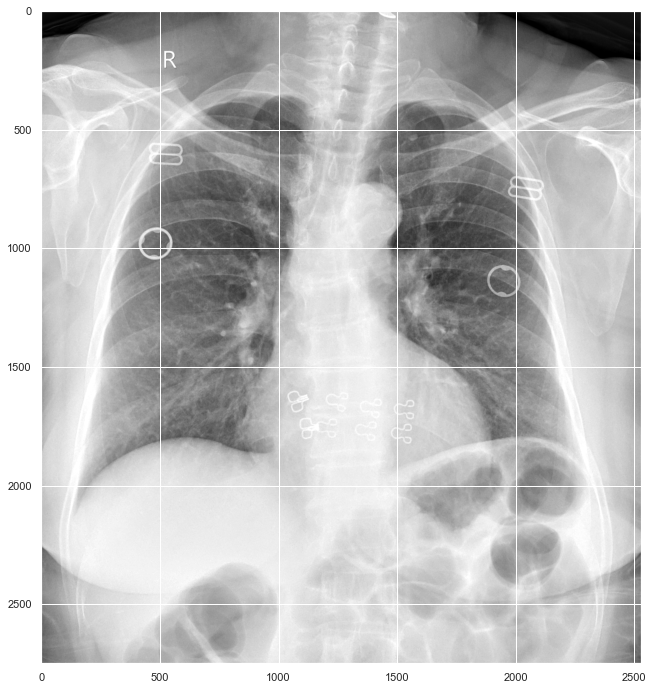

In [6]:
# Choose a random radiograph to display
os.chdir('./data/train')
img = read_xray(random.choice(os.listdir("./data/train")))
plt.figure(figsize = (12,12))
plt.imshow(img, 'gray')

It's important to recognize that the origin or 0,0 point on the picture is in the top-left, and not the bottom-left as is traditional. Radiographs will also have either an 'R' or 'L' to indicate the patient's right or left side to help the examining radiologist properly read the radiograph without having to do too much investigative work.

### Abnormality Classes
There are 15 different abnormality findings with corresponding names and id's

In [42]:
print(ps.sqldf('SELECT DISTINCT class_name AS Name, class_id AS ID FROM train_data ORDER BY ID', locals()))

                  Name  ID
0   Aortic enlargement   0
1          Atelectasis   1
2        Calcification   2
3         Cardiomegaly   3
4        Consolidation   4
5                  ILD   5
6         Infiltration   6
7         Lung Opacity   7
8          Nodule/Mass   8
9         Other lesion   9
10    Pleural effusion  10
11  Pleural thickening  11
12        Pneumothorax  12
13  Pulmonary fibrosis  13
14          No finding  14


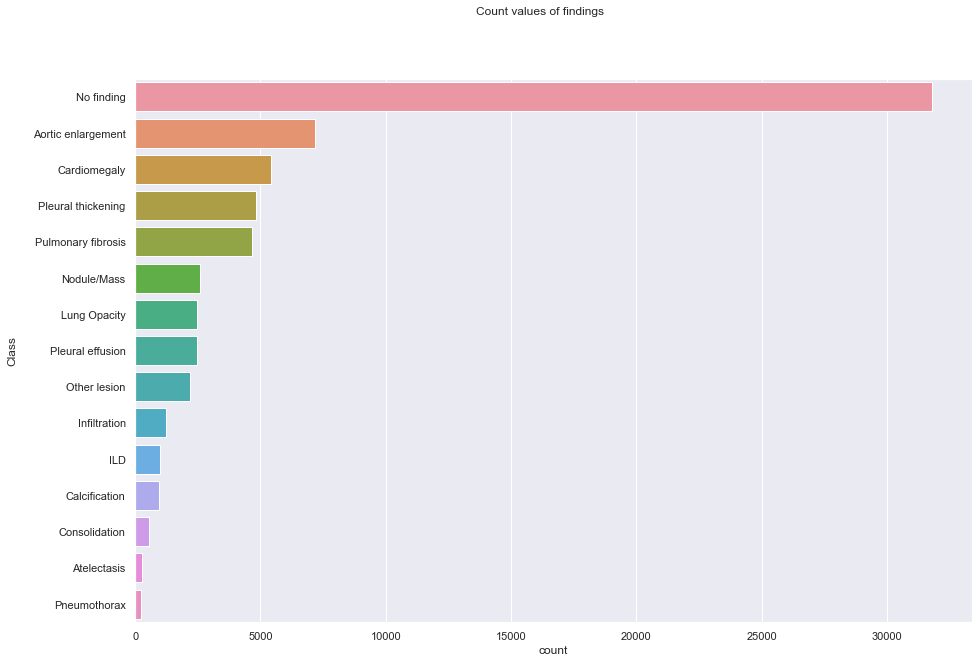

In [7]:
plt.figure(figsize=(15,10))
sns.countplot(y="class_name",
              data=train_data,
              order=train_data['class_name'].value_counts().index)
#plt.xscale('log')
plt.suptitle("Count values of findings")
plt.ylabel("Class\n")
plt.show()

Most of the images have no finding whatsoever, though it seems strange that there can be over double the number of 'No finding' as there are distinct training images (15,000).
That is because every image is examined by exactly 3 different radiologists, so where 2 radiologists didn't report any findings, one might have detected multiple abnormalities, thus accounting for the strange number of 'No finding's.

In [39]:
print(ps.sqldf('SELECT image_id AS Image, COUNT(class_id) AS Abnormalities, COUNT(DISTINCT rad_id) AS Radiologists from train_data GROUP BY image_id ORDER BY Radiologists, Abnormalities DESC', locals()))

                                  Image  Abnormalities  Radiologists
0      03e6ecfa6f6fb33dfeac6ca4f9b459c9             57             3
1      fa109c087e46fe1ea27e48ce6d154d2f             52             3
2      e31be972e181987a8600a8700c1ebe88             48             3
3      3a302fbbbf3364aa1a7731b59e6b98ec             46             3
4      6d5acf3f8a973a26844d617fffe72998             46             3
...                                 ...            ...           ...
14995  ffe07f4f98a7242b460c8d3a8e46832c              3             3
14996  ffea246f04196af602c7dc123e5e48fc              3             3
14997  ffeffc54594debf3716d6fcd2402a99f              3             3
14998  fff0f82159f9083f3dd1f8967fc54f6a              3             3
14999  fff2025e3c1d6970a8a6ee0404ac6940              3             3

[15000 rows x 3 columns]


Average number of findings per image excluding 'No finding' rows:

In [9]:
print(len(train_data.loc[(train_data.class_name != 'No finding')].index) / len(pd.unique(train_data.loc[(train_data.class_name != 'No finding')]['image_id'])))

8.214838416021848


## Radiologists

Radiologists R8, R9, and R10 seem to have a lot more findings than the others, and this could be from experience, some sort of specialty, or who had the most time to invest in the creation of this data set.

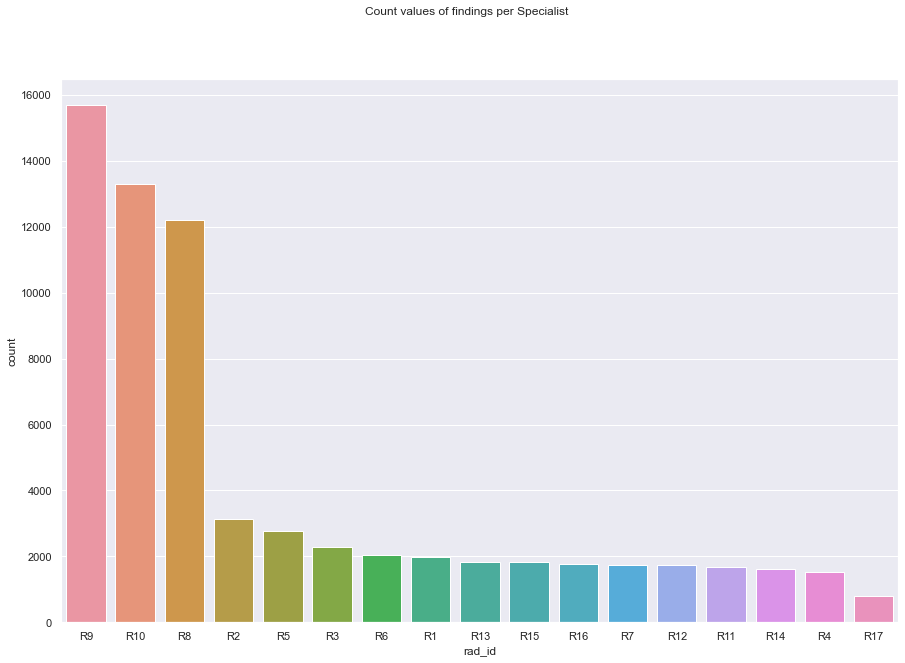

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(x="rad_id",
              data=train_data,
              order=train_data['rad_id'].value_counts().index)
#plt.yscale('log')
plt.suptitle("Count values of findings per Specialist")
plt.show()

To test the hypothesis that those top three radiologists might be specialists in a common ailment, the counts of all their findings were plotted. There doesn't appear to be any variation from the general trend aside from less 'No finding' than would be proportional with number of anomolies detected between the three of them. This suggests either a keen eye developed with years of experience, or Munchausen syndrome by proxy. Most likely the former.

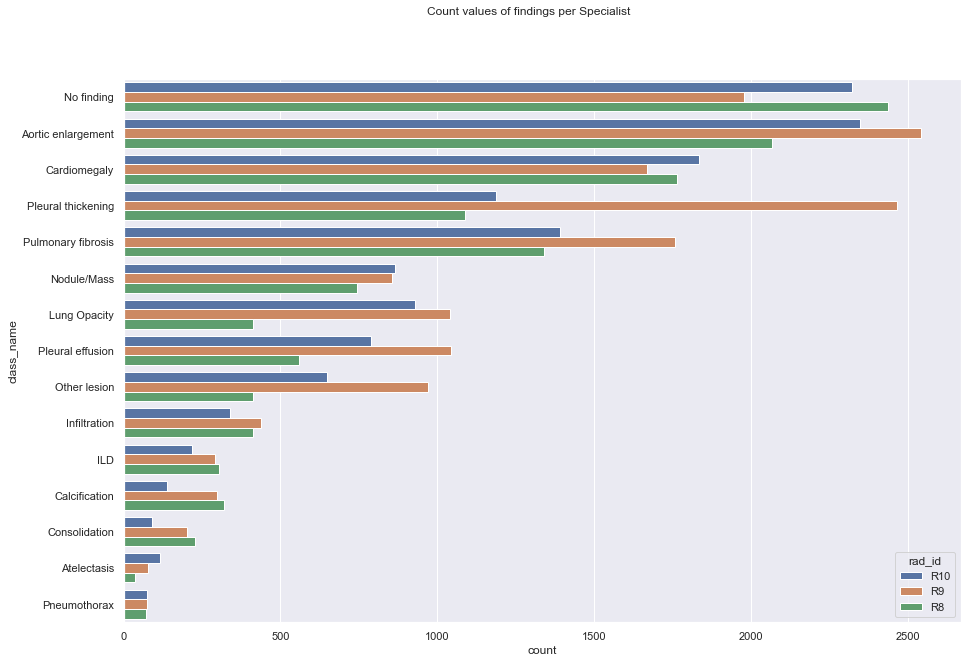

In [36]:
plt.figure(figsize=(15,10))
sns.countplot(y="class_name",
              data=train_data.loc[(train_data.rad_id.isin(['R8', 'R9', 'R10']))],
              hue='rad_id',
              order=train_data['class_name'].value_counts().index)
#plt.yscale('log')
plt.suptitle("Count values of findings per Specialist")
plt.show()

It's also possible that some classifications are more likely to be found in specific sections across the radiograph. To test this, the center of each abnormality was calculated using the average of both x's and y's, and plotted into a density graph as seen below.

In [11]:
avg_loc = train_data.loc[(train_data.class_name != 'No finding'), ['class_name', 'x_max', 'x_min', 'y_max', 'y_min']]
avg_loc['x_avg'] = avg_loc.groupby(['x_max','x_min'], group_keys=False).apply(lambda g: (g.x_max + g.x_min) / 2)
avg_loc['y_avg'] = avg_loc.groupby(['y_max','y_min'], group_keys=False).apply(lambda g: (g.y_max + g.y_min) / 2)
avg_loc.head()

,class_name,x_max,x_min,y_max,y_min,x_avg,y_avg
2,Cardiomegaly,1653.0,691.0,1831.0,1375.0,1172.0,1603.0
3,Aortic enlargement,1611.0,1264.0,1019.0,743.0,1437.5,881.0
5,Pleural thickening,947.0,627.0,433.0,357.0,787.0,395.0
6,ILD,2188.0,1347.0,2169.0,245.0,1767.5,1207.0
7,Nodule/Mass,675.0,557.0,2484.0,2352.0,616.0,2418.0


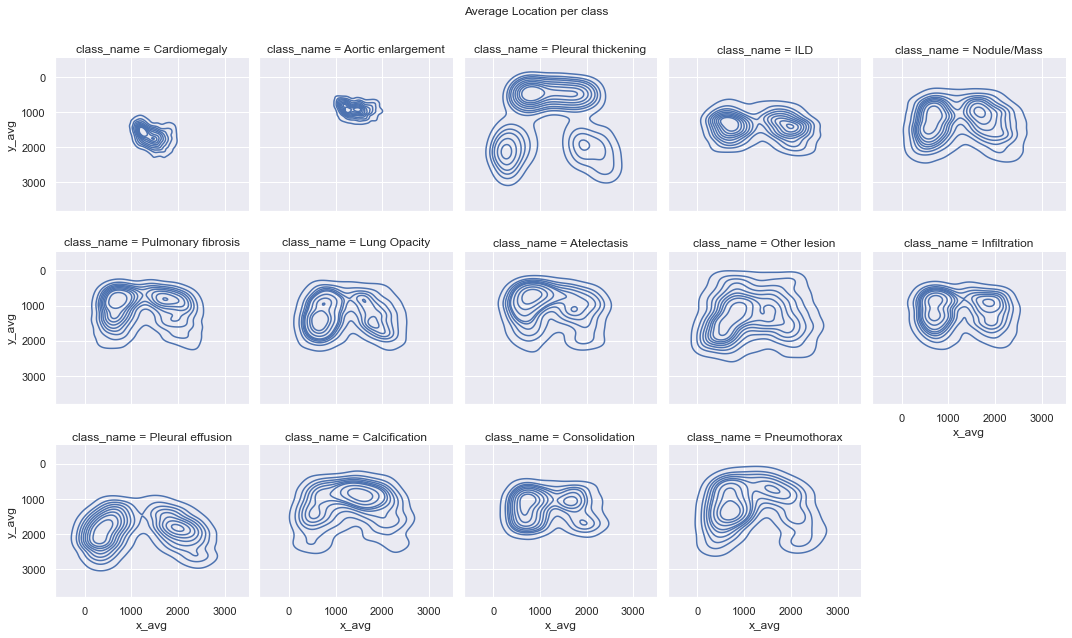

In [12]:
g = sns.FacetGrid(avg_loc,
                  col='class_name',
                  col_wrap = 5)
g.map(sns.kdeplot, 'x_avg', 'y_avg')
g.fig.axes[0].invert_yaxis()
g.fig.suptitle('Average Location per class')
g.fig.subplots_adjust(top=0.9)

Some were more obviously correlated such as Cardiomegaly and Aortic enlargement, but others had slight trends towards being exclusively in the lower lungs and others in-between or accross the top of the chest cavity.